In [1]:
import pandas
import time
import github
import gpt
import Score

In [2]:
def run_experiment(csvFile):
    for i in range(0, len(csvFile)):
        repo_identifier = csvFile.iloc[i]['GitHub_Repo_Link'].split('github.com/')[1]
        print(repo_identifier)
        try:
            default_branch = github.get_default_branch(repo_identifier);
            repo_structure = github.get_repository_tree(repo_identifier, default_branch)
            recursive_repo_structure = github.get_recursive_repository_tree(repo_identifier, default_branch)
            dependencies = github.get_list_of_dependencies(repo_identifier)
            build_file_content = csvFile.iloc[i]['GitHub_Build_Pipeline_File_Content']
            repo_language = csvFile.iloc[i]['Language']

            generated_workflow_file = gpt.generate_build_pipeline(repo_structure, dependencies, default_branch, recursive_repo_structure)

            csvFile.loc[i,'Generated_Build_Pipeline_File_Content'] = generated_workflow_file
            valid_syntax = github.run_action_lint(generated_workflow_file);
            if not valid_syntax:
                csvFile.loc[i,'Syntax_Check'] = 'Invalid'
                continue

            csvFile.loc[i,'Syntax_Check'] = 'Valid'
            
            exact_match_score = Score.get_exact_match_score(generated_workflow_file, build_file_content)
            bleu_score = Score.get_bleu_score(generated_workflow_file, build_file_content)
            devops_aware_score = Score.get_devops_aware_score(generated_workflow_file, build_file_content, repo_language)

            csvFile.loc[i,'Exact_Match_Score'] = exact_match_score
            csvFile.loc[i,'BLEU_Score'] = bleu_score
            csvFile.loc[i,'DevOps_Aware_Score'] = devops_aware_score
            # Add delay to avoid rate limiting
            #time.sleep(5)
        except Exception as e:
            print(e)
            continue

    csvFile.to_csv('dataset/output.csv', index=False)

In [5]:
# reading the CSV file
csvFile = pandas.read_csv('dataset/filtered_repos.csv')

# Pre-processing the CSV file
csvFile = csvFile[csvFile['GitHub_Repo_Link'].notna()]

# Explicitly specify dtypes to avoid pandas inferring dtypes
csvFile = csvFile.astype({'GitHub_Repo_Link': 'string', 'GitHub_Build_Pipeline_File_Content': 'string', 'Generated_Build_Pipeline_File_Content': 'string', 'Syntax_Check': 'string', 'Exact_Match_Score': 'float', 'BLEU_Score': 'float', 'DevOps_Aware_Score': 'float'})

csvFile

,Index,GitHub_Repo_Link,GitHub_Build_Pipeline_File_Content,Generated_Build_Pipeline_File_Content,Exact_Match_Score,BLEU_Score,Syntax_Check,DevOps_Aware_Score,Language
0,1,https://github.com/sparklemotion/nokogiri,"name: upstream concurrency: group: ""${{githu...",<NA>,NaN,NaN,<NA>,NaN,C
1,2,https://github.com/connectbot/connectbot,name: Continuous Integration on: push: ...,<NA>,NaN,NaN,<NA>,NaN,Java
2,3,https://github.com/bwaldvogel/liblinear-java,name: CI on: push: branches: [ main ] ...,<NA>,NaN,NaN,<NA>,NaN,Java
3,4,https://github.com/twitter4j/twitter4j,# This workflow will build a Java project with...,<NA>,NaN,NaN,<NA>,NaN,Java
4,5,https://github.com/rzwitserloot/lombok,name: Tests on: push: pull_request: jobs...,<NA>,NaN,NaN,<NA>,NaN,Java
...,...,...,...,...,...,...,...,...,...
2127,2128,https://github.com/hanskristian-work/vkd3d-proton,"name: Test Builds on Linux on: [push, pull_re...",<NA>,NaN,NaN,<NA>,NaN,C
2128,2129,https://github.com/cofyc/argparse,name: ci on: push: branches: - mast...,<NA>,NaN,NaN,<NA>,NaN,C
2129,2130,https://github.com/adafruit/adafruit_nrf52_ard...,"name: Build on: [pull_request, push] concurr...",<NA>,NaN,NaN,<NA>,NaN,C
2130,2131,https://github.com/godotexplorer/ecmascript,name: 🐧 Linux Builds on: workflow_call: ...,<NA>,NaN,NaN,<NA>,NaN,C


In [6]:
run_experiment(csvFile)

sparklemotion/nokogiri
Command '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
workflow.yml:1:1: "on" section is missing in workflow [syntax-check]
  |
1 | name: Build and Test
  | ^~~~~
workflow.yml:1:1: "jobs" section is missing in workflow [syntax-check]
  |
1 | name: Build and Test
  | ^~~~~
connectbot/connectbot
bwaldvogel/liblinear-java
twitter4j/twitter4j
workflow.yml:18:Command '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
rzwitserloot/lombok
13: missing input "distribution" which is required by action "actions/setup-java@v2". all required inputs are "distribution", "java-version" [action]
   |
18 |       uses: actions/setup-java@v2
   |             ^~~~~~~~~~~~~~~~~~~~~
workflow.ymlCommand '['actionlint', 'workflow.yml']' returned non-zero exit status 1.
apache/hive
:18:15: missing input "distribution" which is required by action "actions/setup-java@v2". all required inputs are "distribution", "java-version" [action]
   |
18 |         uses

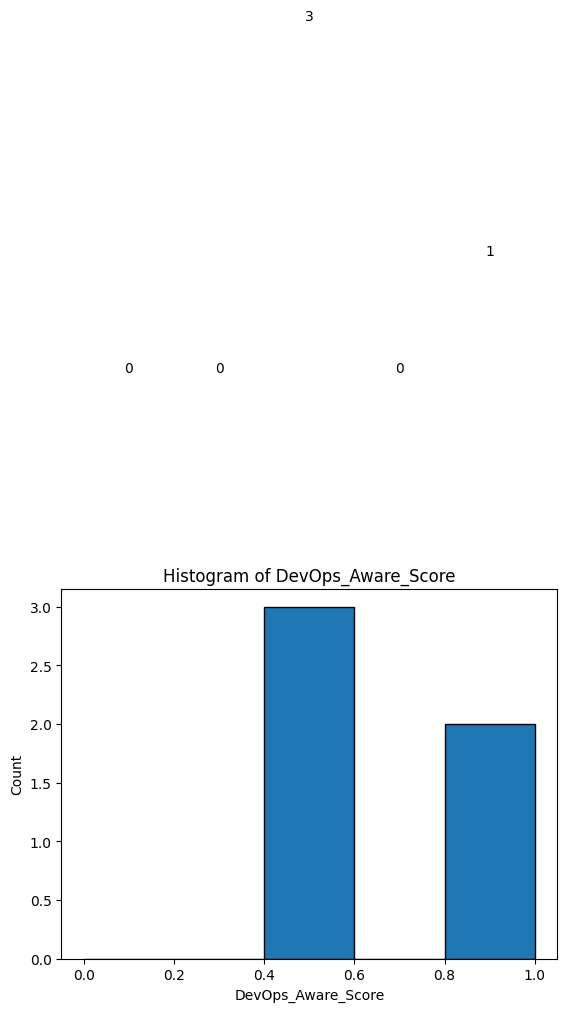

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# read the csv file
df = pd.read_csv('dataset/output.csv')

# filter out rows with empty DevOps_Aware_Score
df = df[df['DevOps_Aware_Score'].notna()]

# create histogram
plt.hist(df['DevOps_Aware_Score'], bins=5, range=(0, 1), edgecolor='black')

# set labels and title
plt.xlabel('DevOps_Aware_Score')
plt.ylabel('Count')
plt.title('Histogram of DevOps_Aware_Score')

# show count on top of each histogram
for i in range(5):
    count = len(df[(df['DevOps_Aware_Score'] >= i*0.2) & (df['DevOps_Aware_Score'] < (i+1)*0.2)])
    plt.text(i*0.2+0.1, count+5, str(count), ha='center')

# show the plot
plt.show()
